In [1]:
import pandas as pd
import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from gensim.models import FastText
from sklearn.manifold import TSNE
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

pd.set_option('display.max_colwidth', None)

# Read CSV

In [19]:
file_path = ['df_kontan_labeled.csv','df_labeled.csv']

df = pd.concat(
    (pd.read_csv(f)for f in file_path),ignore_index=True
)

In [20]:
df.to_csv('df_all_labeled.csv',index=False)

In [4]:
def normal_eda(dataframe):
    callers_locals = inspect.currentframe().f_back.f_locals
    var_names = [name for name, val in callers_locals.items() if val is dataframe]
    var_name = var_names[0] if var_names else "dataframe"
    print(f"EDA for {var_name}")
    print()
    dataframe.info()
    print(f"\nDuplicate Count: {dataframe.duplicated().sum()}")
    print(f"Null Values Count: {dataframe.isna().sum().sum()}")
    print("\nLabel Value Counts:")
    print(dataframe['label'].value_counts())


In [5]:
normal_eda(df)

EDA for df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           1908 non-null   object
 1   domain        1908 non-null   object
 2   title         1908 non-null   object
 3   date          1908 non-null   object
 4   clean_text    1908 non-null   object
 5   label         1908 non-null   object
 6   label_reason  1908 non-null   object
dtypes: object(7)
memory usage: 104.5+ KB

Duplicate Count: 0
Null Values Count: 0

Label Value Counts:
label
Neutral      1388
Inflation     287
Deflation     233
Name: count, dtype: int64


As you can see that the labelled values are dominantly with Neutral (1388), then Inflation (287), and last Deflation (233)

In [6]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# EDA Final Data

In [7]:
plt.style.use("fivethirtyeight")
color_map = {
    "Inflation": "#F28B82",  
    "Deflation": "#81D4FA",  
    "Neutral":  "#F2C879"    
}

## Label Distribution

Text(0.5, 1.0, 'Sentiment Label Distribution')

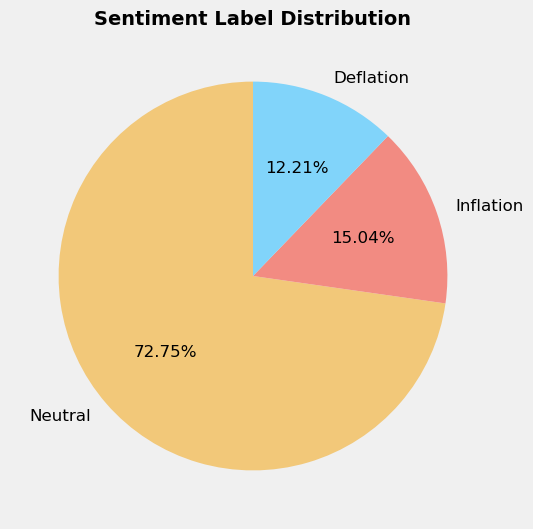

In [8]:
label_counts = df["label"].value_counts()

fig,ax = plt.subplots(figsize=(6,6))
ax.pie(
    label_counts,
    labels=label_counts.index,
    autopct="%.2f%%",
    startangle=90,
    colors=[color_map[label] for label in label_counts.index],
    textprops={'fontsize':12, "color":"Black"}
)
ax.set_title("Sentiment Label Distribution", fontsize = 14, fontweight = "bold")

## Label Count Over Time

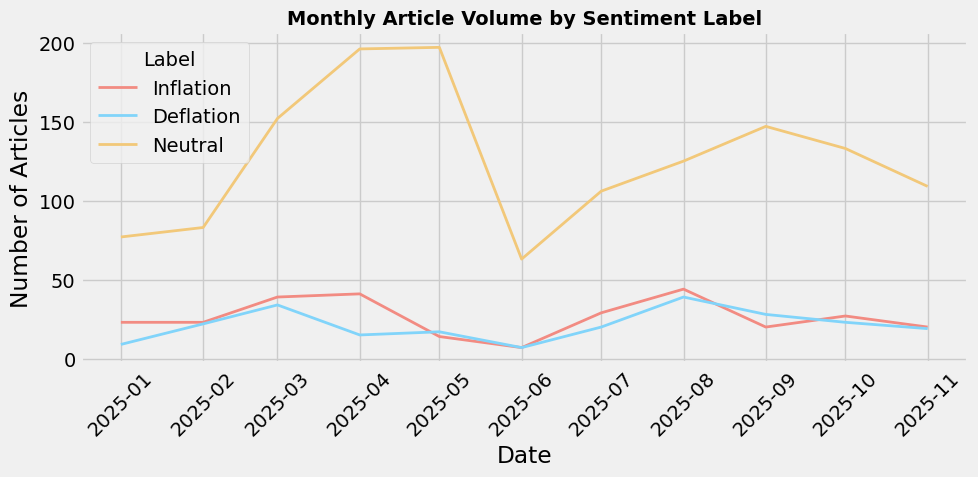

In [9]:
df["year_month"] = df["date"].dt.to_period("M")
monthly_counts = df.groupby(["year_month","label"]).size().reset_index(name="count")

# pivot plotting
pivot_monthly = monthly_counts.pivot(index="year_month",columns="label",values="count")
pivot_monthly.index = pivot_monthly.index.to_timestamp()  

fig, ax = plt.subplots(figsize=(10, 5))
for label in color_map:
    if label in pivot_monthly.columns:
        ax.plot(
            pivot_monthly.index,
            pivot_monthly[label],
            label=label,
            color=color_map[label],
            linewidth=2
        )

ax.set_title("Monthly Article Volume by Sentiment Label", fontsize=14, fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Articles")
ax.legend(title="Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Monthly Trend By Year

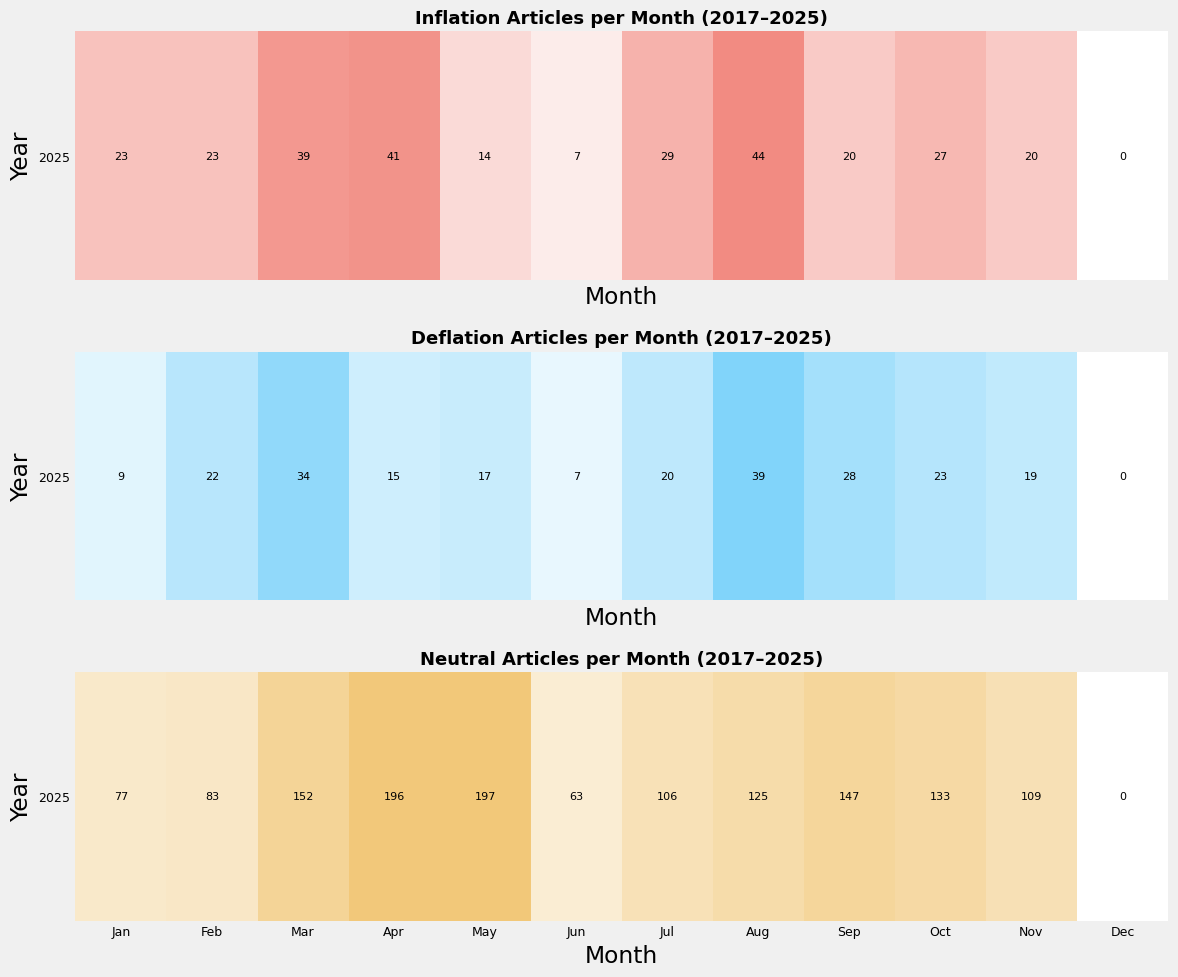

In [10]:
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df = df[df["year"].between(2017, 2025)]

monthly_counts = (
    df.groupby(["year", "month", "label"])
      .size()
      .reset_index(name="count")
)

labels = ["Inflation", "Deflation", "Neutral"]
years = sorted(df["year"].unique())
months = range(1, 13)
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
fig, axes = plt.subplots(len(labels), 1, figsize=(12, 10), sharex=True)

for i, label in enumerate(labels):
    subset = monthly_counts[monthly_counts["label"] == label]
    pivot = subset.pivot(index="year", columns="month", values="count").fillna(0)
    data = pivot.reindex(index=years, columns=months, fill_value=0).values

    ax = axes[i]
    ax.set_facecolor("white") 
    norm_data = data / data.max() if data.max() > 0 else data
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            ax.add_patch(plt.Rectangle(
                (x-0.5, y-0.5), 1, 1,
                color=color_map[label],
                alpha=norm_data[y, x],
                lw=0,          
                ec=None
            ))
            ax.text(x, y, str(int(data[y, x])), ha="center", va="center", color="black", fontsize=8)

    ax.set_xlim(-0.5, len(months)-0.5)
    ax.set_ylim(len(years)-0.5, -0.5)
    ax.set_xticks(np.arange(len(months)))
    ax.set_xticklabels(month_labels, rotation=0, fontsize=9)
    ax.set_yticks(np.arange(len(years)))
    ax.set_yticklabels(years, fontsize=9)
    ax.tick_params(length=0)

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)

    ax.set_title(f"{label} Articles per Month (2017–2025)", fontsize=13, fontweight="bold")
    ax.set_ylabel("Year")
    ax.set_xlabel("Month")

plt.tight_layout()
plt.show()


## SENTIMENT REASON FREQUENCY

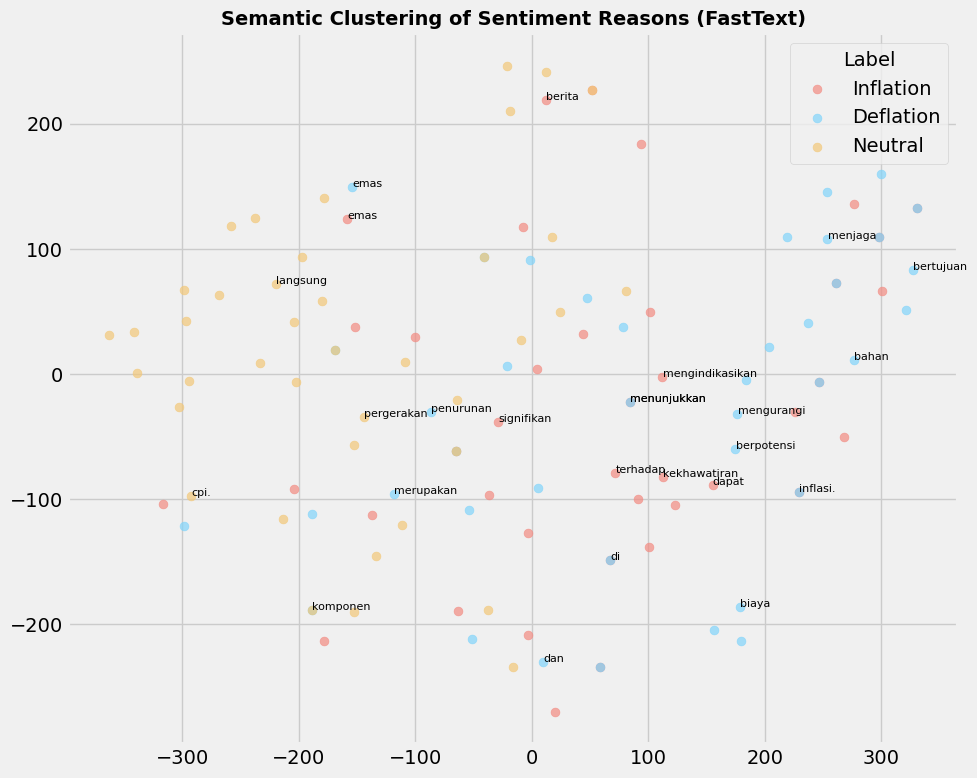

In [12]:
df["tokens"] = df["label_reason"].astype(str).str.lower().str.split()

model = FastText(
    sentences=df["tokens"],
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,      
    epochs=10
)

def top_words(df, label, n=50):
    words = [w for tokens in df[df["label"] == label]["tokens"] for w in tokens]
    freq = Counter(words)
    return [w for w, _ in freq.most_common(n)]

words_to_plot = []
labels_to_plot = []
for label in df["label"].unique():
    w = top_words(df, label, n=40)
    words_to_plot.extend(w)
    labels_to_plot.extend([label]*len(w))

words_vec = [w for w in words_to_plot if w in model.wv.key_to_index]
vecs = [model.wv[w] for w in words_vec]
labels_used = [labels_to_plot[i] for i, w in enumerate(words_to_plot) if w in model.wv.key_to_index]

tsne = TSNE(n_components=2, random_state=42, perplexity=20, learning_rate=200)
vecs = np.array(vecs)
reduced = tsne.fit_transform(vecs)
reduced = tsne.fit_transform(vecs)
tsne_df = pd.DataFrame(reduced, columns=["x", "y"])
tsne_df["word"] = words_vec
tsne_df["label"] = labels_used

fig, ax = plt.subplots(figsize=(10, 8))
for label in color_map:
    subset = tsne_df[tsne_df["label"] == label]
    ax.scatter(subset["x"], subset["y"], color=color_map[label],
               label=label, alpha=0.7, s=40)

for _, row in tsne_df.sample(25, random_state=1).iterrows():
    ax.text(row["x"]+0.3, row["y"], row["word"], fontsize=8)

ax.set_title("Semantic Clustering of Sentiment Reasons (FastText)", fontsize=14, fontweight="bold")
ax.legend(title="Label")
plt.tight_layout()
plt.show()

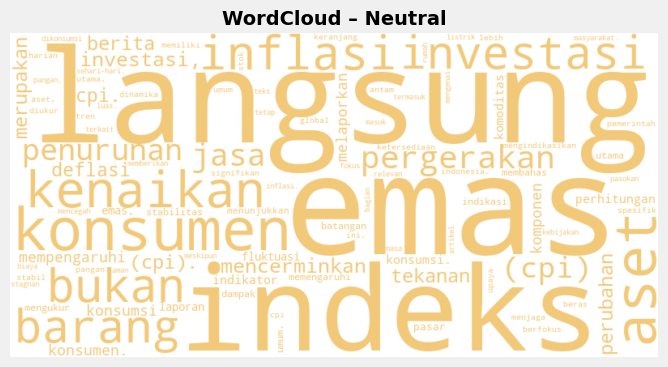

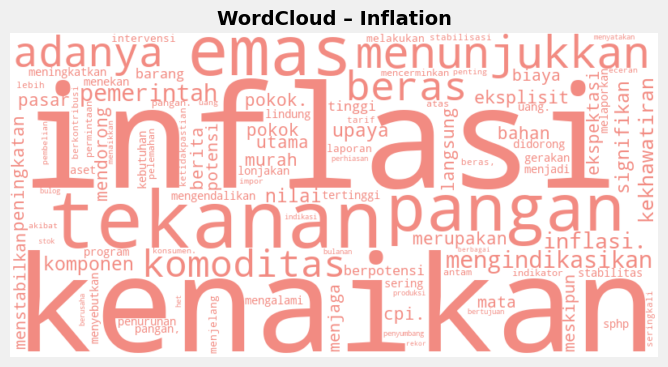

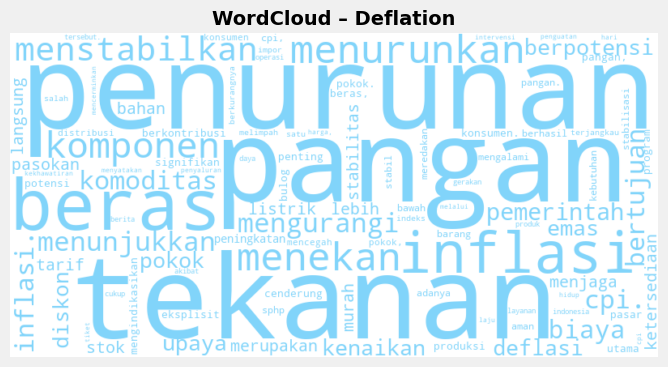

In [13]:
stopwords = set(StopWordRemoverFactory().get_stop_words())
custom_words = {"harga"}
stopwords.update(custom_words)


def top_terms_by_label(df, label_col="label", text_col="label_reason", top_n=100):
    results = {}
    for label in df[label_col].unique():
        subset = df[df[label_col] == label]
        all_words = " ".join(subset[text_col].astype(str)).lower()
        tokens = [
            w for w in all_words.split()
            if len(w) > 2 and w not in stopwords
        ]
        freq = Counter(tokens)
        results[label] = dict(freq.most_common(top_n))
    return results

top_terms = top_terms_by_label(df)

for label in top_terms:
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        color_func=lambda *args, **kwargs: color_map[label]
    ).generate_from_frequencies(top_terms[label])

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud – {label}", fontsize=14, fontweight="bold")
    plt.show()

## Text Length Vs Label

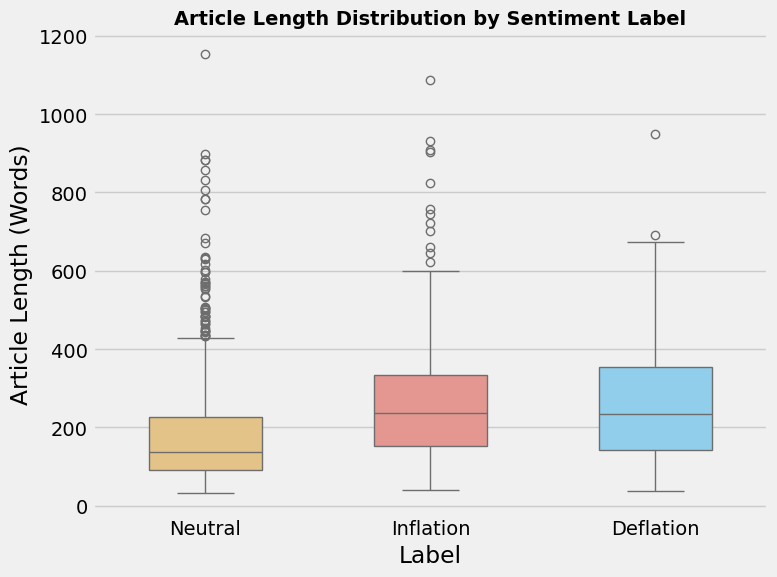

In [14]:
df["text_len"] = df["clean_text"].apply(lambda x: len(str(x).split()))

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x="label", y="text_len", data=df,hue = 'label',
            palette=color_map, width=0.5, ax=ax)
ax.set_title("Article Length Distribution by Sentiment Label", fontsize=14, fontweight="bold")
ax.set_xlabel("Label")
ax.set_ylabel("Article Length (Words)")
plt.tight_layout()
plt.show()


In [15]:
summary_stats = df.groupby('label')['text_len'].describe()
print(summary_stats)

            count        mean         std   min    25%    50%     75%     max
label                                                                        
Deflation   233.0  264.815451  154.966418  37.0  141.0  234.0  354.00   948.0
Inflation   287.0  271.393728  168.878225  39.0  152.5  236.0  334.50  1087.0
Neutral    1388.0  176.976945  120.829974  33.0   91.0  136.0  227.25  1153.0


In [16]:
summary_stats_all = df['text_len'].describe()
print(summary_stats_all)

count    1908.000000
mean      201.905660
std       139.571216
min        33.000000
25%        97.000000
50%       178.000000
75%       242.000000
max      1153.000000
Name: text_len, dtype: float64


## Total Article Volume Overtime

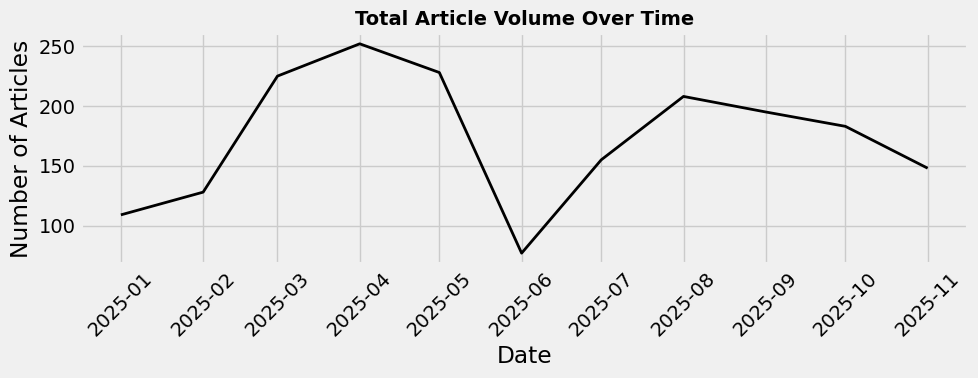

In [18]:
monthly_total = df.groupby(df["date"].dt.to_period("M")).size().reset_index(name="count")
monthly_total["date"] = monthly_total["date"].dt.to_timestamp()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(monthly_total["date"], monthly_total["count"], color="black", linewidth=2)
ax.set_title("Total Article Volume Over Time", fontsize=14, fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()